# 2.0 Creating a Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf  # customized help functions

%matplotlib inline

df = pd.read_csv('data/ai4i2020.csv')

X = df.drop(columns='Machine failure')
y = df['Machine failure']

# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Create a baseline model

### 1. Build a Logistic Regression model using pipeline

In [2]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
pipe = hf.create_pipe(clf)

In [3]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('proc_cols',
                 FunctionTransformer(func=<function col_name_cnvt at 0x0000023CB6CC4700>)),
                ('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023CB3B81BB0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023CB3B81160>)])),
                ('model', LogisticRegression())])

### 2. Evaluate the model performance

#### Use hard decision

In [4]:
y_pred = pipe.predict(X_test)

{'recall': 0.17647058823529413,
 'precision': 0.8571428571428571,
 'f1': 0.29268292682926833}

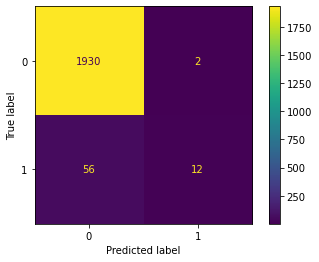

In [5]:
hf.evaluate(y_test, y_pred)

- Hard decision does not do a good job, the recall is very low.

#### Use soft decision

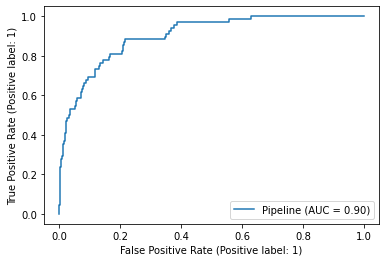

In [6]:
# Search for the best cutoff threshold
# It seems the 0.15 is a good choice
hf.RocCurveDisplay.from_estimator(pipe, X_test, y_test);

In [7]:
# def soft_to_hard(model, X_test, cutoff):
#     y_probs = model.predict_proba(X_test)
#     y_hats = [1 if y_prob[1] > cutoff else 0 for y_prob in y_probs]
#     return y_hats

{'recall': 0.5294117647058824,
 'precision': 0.3364485981308411,
 'f1': 0.4114285714285714}

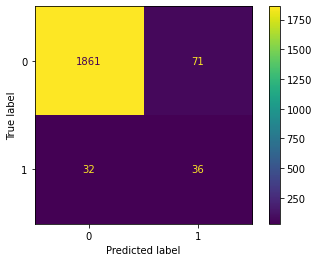

In [19]:
# Seems reasonable to set the cutoff point at 0.13
# and calculate the lables
y_hats = hf.soft_to_hard(pipe, X_test, cutoff=0.13)
hf.evaluate(y_test, y_hats)

Given the recall a more important metrics, we choise the cutoff of 0.13. The bare-bone Logistic Regression achieves Recall of **~53%**, and the precision of **~34%**. 

### Cross validation

In [26]:
from sklearn.model_selection import StratifiedKFold, KFold

k_fold = 30        # set 30 splits
kf = KFold(n_splits=k_fold)

# do the split and train
scores = []
for train_idx, test_idx in kf.split(X_train):    
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]    
    
    pipe.fit(X_train_fold, y_train_fold)
    y_hats = hf.soft_to_hard(pipe, X_test_fold, cutoff=0.13)  # use the same cutoff value
    score = hf.evaluate(y_test_fold, y_hats, cm=False)
    scores.append(score)

In [27]:
# calculate the average recall, precision, and f1
recall, precision, f1 = [], [], []
for score in scores:    
    recall.append(score['recall'])
    precision.append(score['precision'])
    f1.append(score['f1'])
print('Mean Recall: ', np.array(recall).mean())
print('Mean Precision: ', np.array(precision).mean())
print('Mean F1: ', np.array(f1).mean())

Mean Recall:  0.6198563473563473
Mean Precision:  0.3575832522622131
Mean F1:  0.43919371986615463


- The soft decision with cross validation shows a better result.

### Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__penalty': ['elasticnet'],
    'model__max_iter': [500, 1000, 2000, 5000],
    'model__l1_ratio': [0, 0.5, 1],
    'model__solver': ['saga']
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=20, scoring='recall', refit=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('proc_cols',
                                        FunctionTransformer(func=<function col_name_cnvt at 0x0000023CB6CC4700>)),
                                       ('prep',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000023CB3B81BB0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000023CB3B81160>)])),
                                       ('model', LogisticRegression())]),

In [24]:
grid.best_params_

{'model__l1_ratio': 0.5,
 'model__max_iter': 500,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

{'recall': 0.5294117647058824,
 'precision': 0.33962264150943394,
 'f1': 0.41379310344827586}

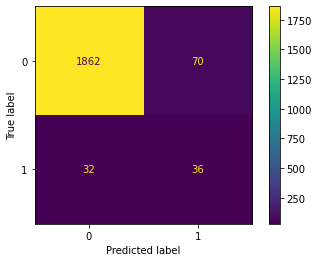

In [25]:
y_grid_probs = grid.predict_proba(X_test)
y_grid_hats = [1 if y_prob[1] > 0.13 else 0 for y_prob in y_grid_probs]
hf.evaluate(y_test, y_grid_hats)

- Even with the best parameters, the model performance does not improve much. 

